In [ ]:
import os
import urllib.request
urllib.request.urlretrieve('http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar', 'VOCtrainval_06-Nov-2007.tar')

# Data loading and utils definitions

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
imgs_path ='/content/drive/MyDrive/ass4/VOCdevkit/VOC2007/JPEGImages/'

In [3]:

import glob,cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import keras
import gc
import tensorflow as tf
from tensorflow.keras.layers import Add, Conv2D,Dropout, MaxPooling2D,Input, Lambda,UpSampling2D,Activation,Concatenate,LeakyReLU,Conv2DTranspose,PReLU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback,ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

from keras.utils import plot_model



In [4]:
gif_preds = []
class CustomCallback(Callback):
    def __init__(self):
      super(CustomCallback, self).__init__()
      gif_preds = []
    def on_epoch_begin(self, epoch, logs=None):
        gif_preds.append(self.model.predict(test)[1][6])

In [5]:

def psnr(y_true, y_pred):
  return tf.reduce_mean(tf.image.psnr(y_true, y_pred, max_val=1.0))
files = glob.glob(imgs_path+'*.jpg')

In [6]:
path_to_folder = '/content/drive/MyDrive/ass4/'
def get_callback(animation=False,name='t'):
  cp = ModelCheckpoint(path_to_folder+'best_model_weights_{}.h5'.format(name))

  callback = EarlyStopping(monitor='loss', patience=10)
  rlop = ReduceLROnPlateau(patience=5)
  if animation:
    costum_callback = CustomCallback()
    return [cp,callback,rlop,costum_callback]
  return [cp,callback,rlop]


In [7]:

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self,files,batch_size=128,two_outs=True,aug = False):
        'Initialization'
        self.files = files
        self.batch_size=batch_size
        self.two_outs = two_outs
        self.indexes = list(range(len(files)))
        self.aug = aug
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.files) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        # list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(indexes)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        gc.collect()
        # self.indexes = np.arange(len(self.list_IDs))
        # if self.shuffle == True:
        #     np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        x= []
        y_mid = []
        y_large = [] 
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            file = self.files[ID]
            img = cv2.imread(file)/255
            x.append(cv2.resize(img,(72,72)))
            y_mid.append(cv2.resize(img,(144,144)))
            if self.two_outs:
              y_large.append(cv2.resize(img,(288,288)))
            # Store class
            if self.aug:
              image = cv2.rotate(img, cv2.ROTATE_180) 
              x.append(cv2.resize(image,(72,72)))
              y_mid.append(cv2.resize(image,(144,144)))
              if self.two_outs:
                y_large.append(cv2.resize(image,(288,288)))
              image = cv2.flip(img, 0)
              x.append(cv2.resize(image,(72,72)))
              y_mid.append(cv2.resize(image,(144,144)))
              if self.two_outs:
                y_large.append(cv2.resize(image,(288,288)))
        x= np.array(x)
        y_mid = np.array(y_mid)
        if self.two_outs:
          y_large = np.array(y_large)
          return x,(y_mid,y_large)
        return x,y_mid

In [8]:
def get_generator(two_outs=True,batch_size=128,aug=False):
  train_gen = DataGenerator(files[0:4000],batch_size,two_outs,aug)
  val_gen = DataGenerator(files[4000:5000],batch_size,two_outs,aug)
  return train_gen,val_gen
test = []
test_mid = []
test_large = []
for file in tqdm(files[5000:5012]):
    img = cv2.imread(file)/255
    test.append(cv2.resize(img,(72,72)))
    test_mid.append(cv2.resize(img,(144,144)))
    test_large.append(cv2.resize(img,(288,288)))
    
test = np.array(test)

100%|██████████| 11/11 [00:04<00:00,  2.21it/s]


In [9]:
def img_plot(i,x,y_mid,y_large):
  fig,ax = plt.subplots(1,3,figsize=(25,8))
  ax[0].imshow(x[i])
  ax[1].imshow(y_mid[i])
  ax[2].imshow(y_large[i])
#img_plot(5,train[0],train[1],train[2])

In [10]:
%matplotlib inline
def draw_plots(history):
  f, (ax1, ax2) = plt.subplots(1, 2)
  ax1.plot(history.history['loss'], label='Train Loss')
  ax1.plot(history.history['val_loss'], label='Val Loss')
  ax1.title('Model Loss (Mean Squared Error)')
  ax1.xlabel('Epochs')
  ax1.ylabel('Loss')
  ax1.legend()
  ax2.plot(history.history['psnr'], label='Train PSNR')
  ax2.plot(history.history['val_psnr'], label='Test PSNR')
  ax2.title('Model PSNR')
  ax2.xlabel('Epochs')
  ax2.ylabel('PSNR')
  ax2.legend()
  plt.show()

# simple model

In [ ]:

def base_model():
  input = Input(shape=(None, None, 3))
  x = Conv2D(64, kernel_size=3, activation='relu', padding='same')(input)
  x = Conv2D(64, kernel_size=3, activation='relu', padding='same')(x)
  x = UpSampling2D(size=2,interpolation='bilinear')(x)
  x = Conv2D(3, (1,1), activation='sigmoid', padding='same')(x)
  model = Model(inputs=input, outputs=x)
  return model

In [ ]:
model = base_model()
model.compile(optimizer='adam', loss='mse', metrics=[psnr])

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 64)    1792      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, None, None, 64)    36928     
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, None, None, 64)    0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, None, None, 3)     195       
Total params: 38,915
Trainable params: 38,915
Non-trainable params: 0
_________________________________________________________________


In [ ]:
train_gen,val_gen = get_generator(two_outs=False)
history = model.fit(train_gen,validation_data=val_gen,epochs=100,batch_size=64,callbacks=get_callback(name='simple_model'))

Epoch 1/100
31/31 [==============================] - 1870s 60s/step - loss: 0.0675 - psnr: 12.2530 - val_loss: 0.0177 - val_psnr: 18.1296
Epoch 2/100
31/31 [==============================] - 35s 1s/step - loss: 0.0141 - psnr: 19.0588 - val_loss: 0.0088 - val_psnr: 21.3150
Epoch 3/100
31/31 [==============================] - 35s 1s/step - loss: 0.0093 - psnr: 20.9630 - val_loss: 0.0077 - val_psnr: 21.9775
Epoch 4/100
31/31 [==============================] - 35s 1s/step - loss: 0.0081 - psnr: 21.6753 - val_loss: 0.0073 - val_psnr: 22.2959
Epoch 5/100
31/31 [==============================] - 35s 1s/step - loss: 0.0081 - psnr: 21.7030 - val_loss: 0.0071 - val_psnr: 22.4729
Epoch 6/100
31/31 [==============================] - 35s 1s/step - loss: 0.0076 - psnr: 22.0538 - val_loss: 0.0070 - val_psnr: 22.5187
Epoch 7/100
31/31 [==============================] - 35s 1s/step - loss: 0.0076 - psnr: 22.0318 - val_loss: 0.0069 - val_psnr: 22.6608
Epoch 8/100
31/31 [==============================] -

KeyboardInterrupt: ignored

# simple model with two outputs

In [ ]:
def two_outs_model():
  input = Input(shape=(None, None, 3))
  x = Conv2D(64, kernel_size=3, activation='relu', padding='same')(input)
  x = Conv2D(64, kernel_size=3, activation='relu', padding='same')(x)
  x = UpSampling2D(size=2,interpolation='bilinear')(x)
  bigger = UpSampling2D(size=2,interpolation='bilinear')(x)
  bigger_out = Conv2D(3, (1,1), activation='sigmoid', padding='same')(bigger)
  x = Conv2D(3, (1,1), activation='sigmoid', padding='same')(x)
  model = Model(inputs=input, outputs=[x,bigger_out])
  return model

In [ ]:


model_two_out = two_outs_model()
model_two_out.compile(optimizer='adam', loss='mse')

In [ ]:
train_gen,val_gen = get_generator()
model_two_out.fit(train_gen,validation_data=val_gen,epochs=50,callbacks=[callback])

Epoch 1/50
31/31 [==============================] - 47s 2s/step - loss: 0.0149 - conv2d_6_loss: 0.0076 - conv2d_5_loss: 0.0073 - val_loss: 0.0136 - val_conv2d_6_loss: 0.0069 - val_conv2d_5_loss: 0.0066
Epoch 2/50
31/31 [==============================] - 47s 2s/step - loss: 0.0148 - conv2d_6_loss: 0.0076 - conv2d_5_loss: 0.0072 - val_loss: 0.0135 - val_conv2d_6_loss: 0.0069 - val_conv2d_5_loss: 0.0066
Epoch 3/50
31/31 [==============================] - 48s 2s/step - loss: 0.0147 - conv2d_6_loss: 0.0075 - conv2d_5_loss: 0.0072 - val_loss: 0.0135 - val_conv2d_6_loss: 0.0070 - val_conv2d_5_loss: 0.0066
Epoch 4/50
31/31 [==============================] - 47s 2s/step - loss: 0.0147 - conv2d_6_loss: 0.0075 - conv2d_5_loss: 0.0072 - val_loss: 0.0133 - val_conv2d_6_loss: 0.0068 - val_conv2d_5_loss: 0.0065
Epoch 5/50
31/31 [==============================] - 47s 2s/step - loss: 0.0145 - conv2d_6_loss: 0.0075 - conv2d_5_loss: 0.0071 - val_loss: 0.0133 - val_conv2d_6_loss: 0.0068 - val_conv2d_5_los

In [ ]:
model_two_out.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, None, None, 6 1792        input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, None, None, 6 36928       conv2d_9[0][0]                   
__________________________________________________________________________________________________
up_sampling2d_3 (UpSampling2D)  (None, None, None, 6 0           conv2d_10[0][0]                  
____________________________________________________________________________________________

In [ ]:
preds = model_two_out.predict(test)

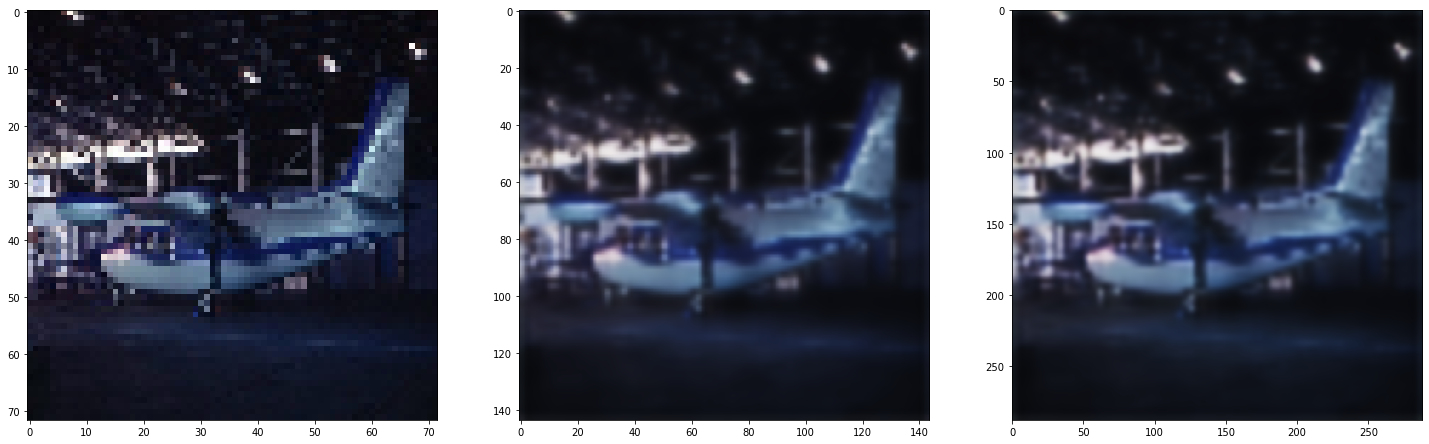

In [ ]:
img_plot(2,test,preds[0],preds[1])

#  residual blocks model

In [ ]:
def res_block(cnl):
  input = Input(shape=(None, None, cnl))
  x = Conv2D(cnl, kernel_size=3, activation='relu', padding='same')(input)
  x = Conv2D(cnl, kernel_size=3, activation='relu', padding='same')(x)
  x = Add()([x, input])
  x = Activation('relu')(x)
  model = Model(inputs=input, outputs = x)
  return model

In [ ]:
def two_outs_res_model():
  input = Input(shape=(None, None, 3))
  
  x = Conv2D(32, kernel_size=3, activation='relu', padding='same')(input)

  x = res_block(32)(x)
  x = res_block(32)(x)
  x = UpSampling2D(size=2,interpolation='bilinear')(x)
  bigger = res_block(32)(x)
  bigger = UpSampling2D(size=2,interpolation='bilinear')(bigger)
  bigger_out = Conv2D(3, (1,1), activation='sigmoid', padding='same',name='big')(bigger)
  x = Conv2D(3, (1,1), activation='sigmoid', padding='same',name='mid')(x)
  model = Model(inputs=input, outputs=[x,bigger_out])
  return model

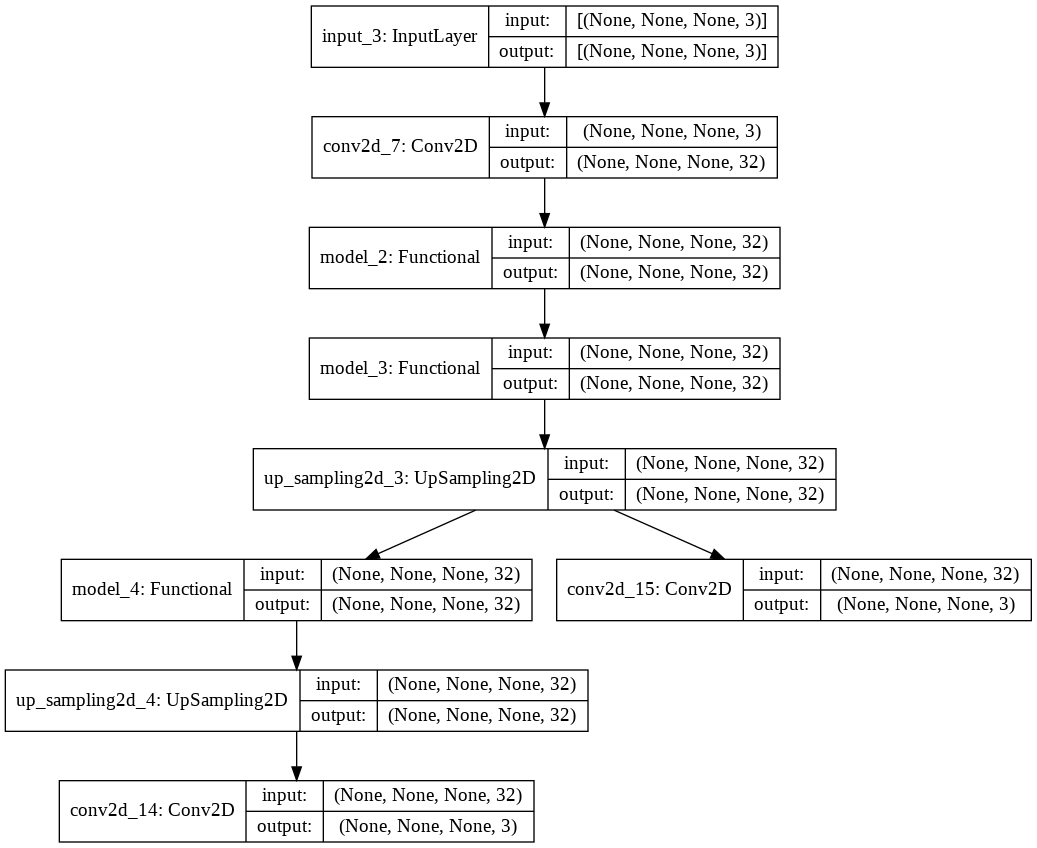

In [ ]:
model_res =two_outs_res_model()
plot_model(model_res, "res_model.png",show_shapes=True)

In [ ]:
model_res.compile(optimizer='adam', loss='mse')
train_gen,val_gen = get_generator()
model_res.fit(train_gen,validation_data=val_gen,epochs=50,callbacks=[callback])

Epoch 1/50
31/31 [==============================] - 48s 2s/step - loss: 0.1404 - conv2d_15_loss: 0.0680 - conv2d_14_loss: 0.0724 - val_loss: 0.0391 - val_conv2d_15_loss: 0.0186 - val_conv2d_14_loss: 0.0205
Epoch 2/50
31/31 [==============================] - 46s 1s/step - loss: 0.0328 - conv2d_15_loss: 0.0164 - conv2d_14_loss: 0.0164 - val_loss: 0.0203 - val_conv2d_15_loss: 0.0105 - val_conv2d_14_loss: 0.0098
Epoch 3/50
31/31 [==============================] - 46s 1s/step - loss: 0.0213 - conv2d_15_loss: 0.0109 - conv2d_14_loss: 0.0104 - val_loss: 0.0180 - val_conv2d_15_loss: 0.0092 - val_conv2d_14_loss: 0.0087
Epoch 4/50
31/31 [==============================] - 46s 1s/step - loss: 0.0191 - conv2d_15_loss: 0.0097 - conv2d_14_loss: 0.0094 - val_loss: 0.0166 - val_conv2d_15_loss: 0.0086 - val_conv2d_14_loss: 0.0080
Epoch 5/50
31/31 [==============================] - 46s 1s/step - loss: 0.0172 - conv2d_15_loss: 0.0088 - conv2d_14_loss: 0.0083 - val_loss: 0.0183 - val_conv2d_15_loss: 0.0088

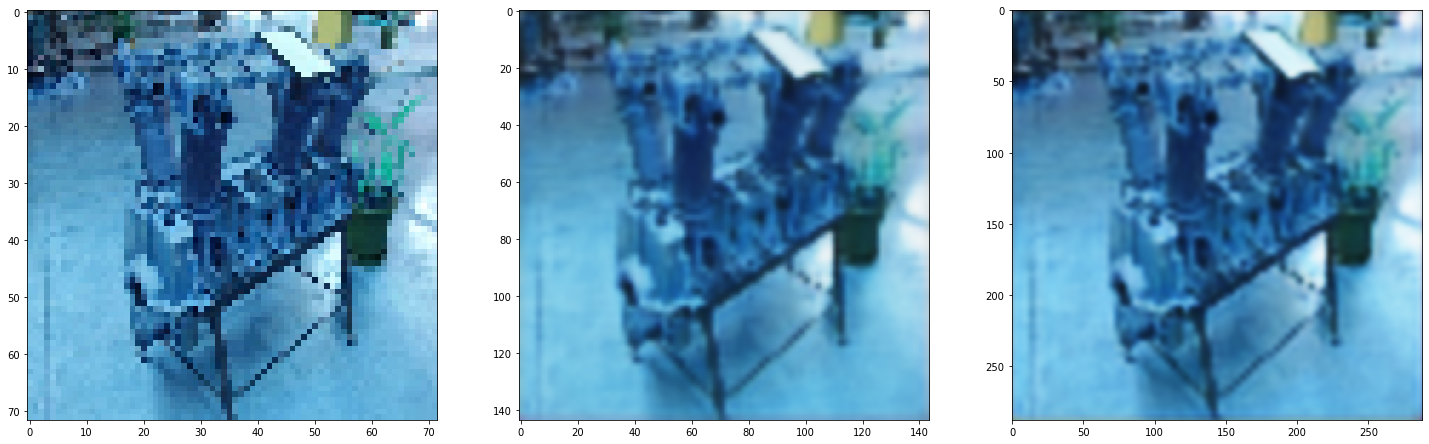

In [ ]:
preds = model_res.predict(test)
img_plot(1,test,preds[0],preds[1])

# dilated_model

In [ ]:
def dilated_block(cnl):
  input = Input(shape=(None, None, cnl))
  d1 = Conv2D(cnl, kernel_size=3,activation=LeakyReLU(alpha=0.2) ,padding='same', dilation_rate=(1,1))(input)
  d2 = Conv2D(cnl, kernel_size=3,activation=LeakyReLU(alpha=0.2) ,padding='same', dilation_rate=(2,2))(input)
  d4 = Conv2D(cnl, kernel_size=3,activation=LeakyReLU(alpha=0.2) ,padding='same', dilation_rate=(4,4))(input)
  x = Concatenate()([d1,d2,d4])
  x = Activation(LeakyReLU(alpha=0.2))(x)
  x = Conv2D(cnl, kernel_size=3, padding='same')(x)
  model = Model(inputs=input, outputs = x)
  return model

In [ ]:
def dilated_model():
  input = Input(shape=(None, None, 3))
  
  x = Conv2D(32, kernel_size=3, activation=LeakyReLU(alpha=0.2), padding='same')(input)

  x = dilated_block(32)(x)
  x = dilated_block(32)(x)
  x = UpSampling2D(size=2,interpolation='bilinear')(x)
  bigger = dilated_block(32)(x)
  bigger = UpSampling2D(size=2,interpolation='bilinear')(bigger)
  bigger_out = Conv2D(3, (1,1), activation='sigmoid', padding='same')(bigger)
  x = Conv2D(3, (1,1), activation='sigmoid', padding='same')(x)
  model = Model(inputs=input, outputs=[x,bigger_out])
  return model

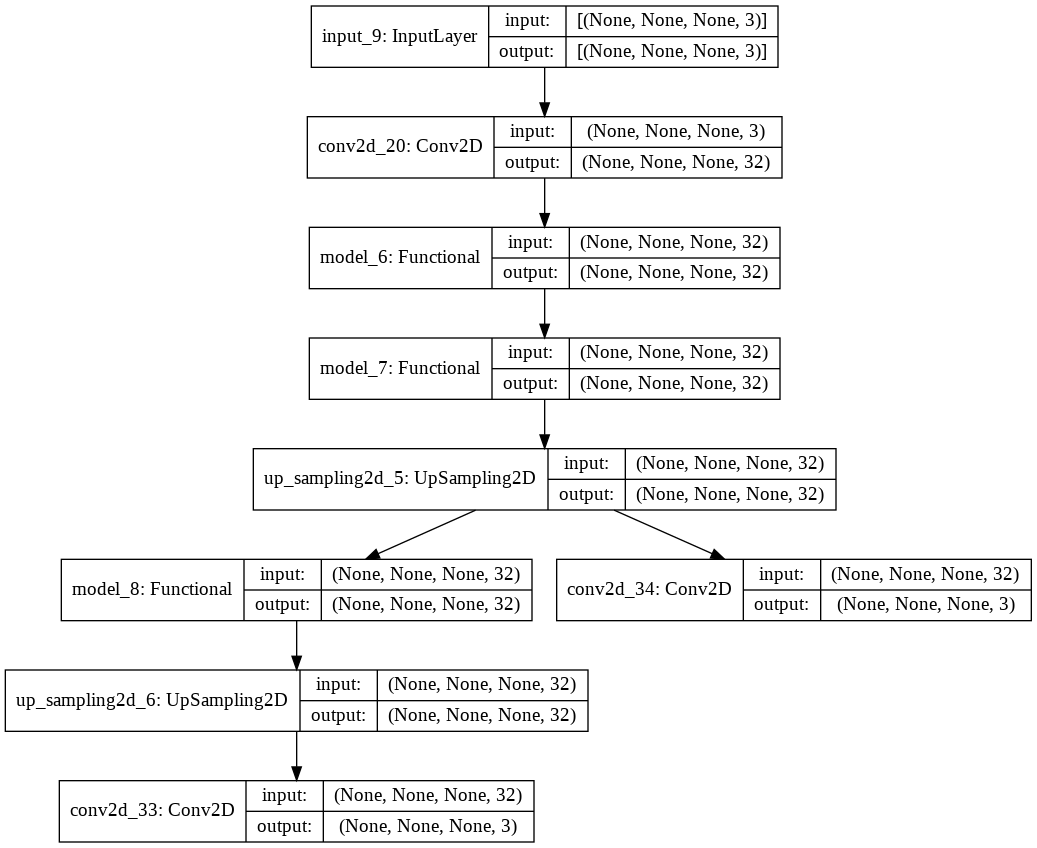

In [ ]:
from keras.utils import plot_model
model_di =dilated_model()
plot_model(model_di, "res_model.png",show_shapes=True)

In [ ]:
model_di.compile(optimizer='adam', loss='mse')
train_gen,val_gen = get_generator()
model_di.fit(train_gen,validation_data=val_gen,epochs=50,callbacks=[callback])


Epoch 1/50
31/31 [==============================] - 52s 2s/step - loss: 0.1072 - conv2d_34_loss: 0.0549 - conv2d_33_loss: 0.0523 - val_loss: 0.0284 - val_conv2d_34_loss: 0.0141 - val_conv2d_33_loss: 0.0143
Epoch 2/50
31/31 [==============================] - 48s 2s/step - loss: 0.0260 - conv2d_34_loss: 0.0127 - conv2d_33_loss: 0.0133 - val_loss: 0.0199 - val_conv2d_34_loss: 0.0099 - val_conv2d_33_loss: 0.0100
Epoch 3/50
31/31 [==============================] - 48s 2s/step - loss: 0.0213 - conv2d_34_loss: 0.0107 - conv2d_33_loss: 0.0106 - val_loss: 0.0175 - val_conv2d_34_loss: 0.0088 - val_conv2d_33_loss: 0.0087
Epoch 4/50
31/31 [==============================] - 48s 2s/step - loss: 0.0183 - conv2d_34_loss: 0.0092 - conv2d_33_loss: 0.0091 - val_loss: 0.0170 - val_conv2d_34_loss: 0.0084 - val_conv2d_33_loss: 0.0085
Epoch 5/50
31/31 [==============================] - 48s 2s/step - loss: 0.0175 - conv2d_34_loss: 0.0088 - conv2d_33_loss: 0.0087 - val_loss: 0.0148 - val_conv2d_34_loss: 0.0075

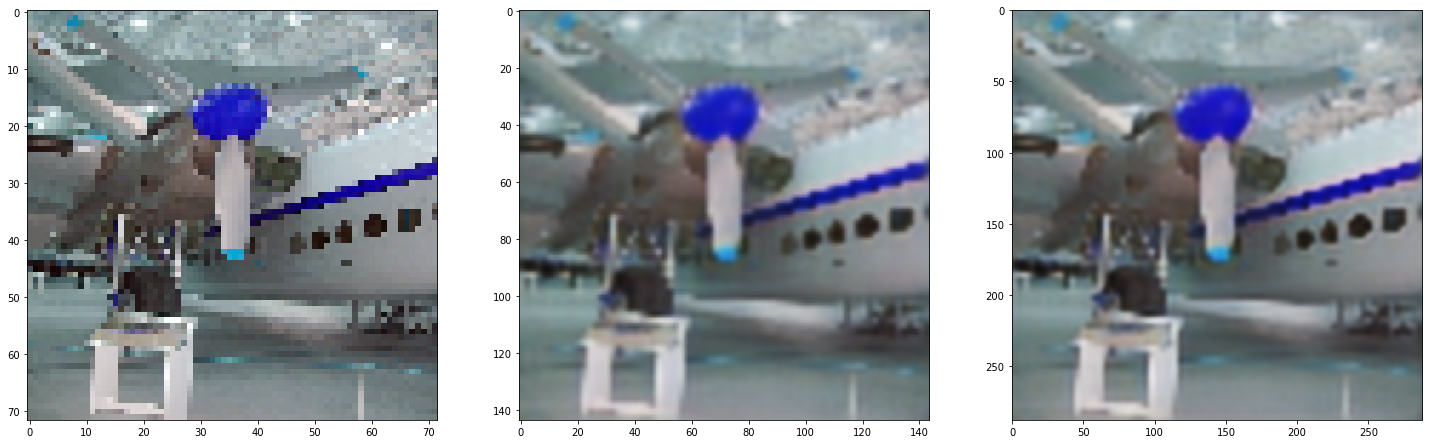

In [ ]:
preds = model_di.predict(test)
img_plot(0,test,preds[0],preds[1])

# VGG model

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
def vgg_model():
  input = Input(shape=(None, None, 3))
  x = Conv2D(64, kernel_size=3, activation='relu', padding='same')(input)
  x = Conv2D(64, kernel_size=3, activation='relu', padding='same')(x)
  vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=input)
  vgg16 = Model(input, vgg16.get_layer('block1_conv2').output)
  for l in vgg16.layers:
    l.trainable=False
  x =  Concatenate()([x, vgg16.outputs[0]])
  x = UpSampling2D(size=2,interpolation='bilinear')(x)
  bigger = UpSampling2D(size=2,interpolation='bilinear')(x)
  bigger_out = Conv2D(3, (1,1), activation='sigmoid', padding='same')(bigger)
  x = Conv2D(3, (1,1), activation='sigmoid', padding='same')(x)
  model = Model(inputs=input, outputs=[x,bigger_out])
  return model

58892288/58889256 [==============================] - 1s 0us/step


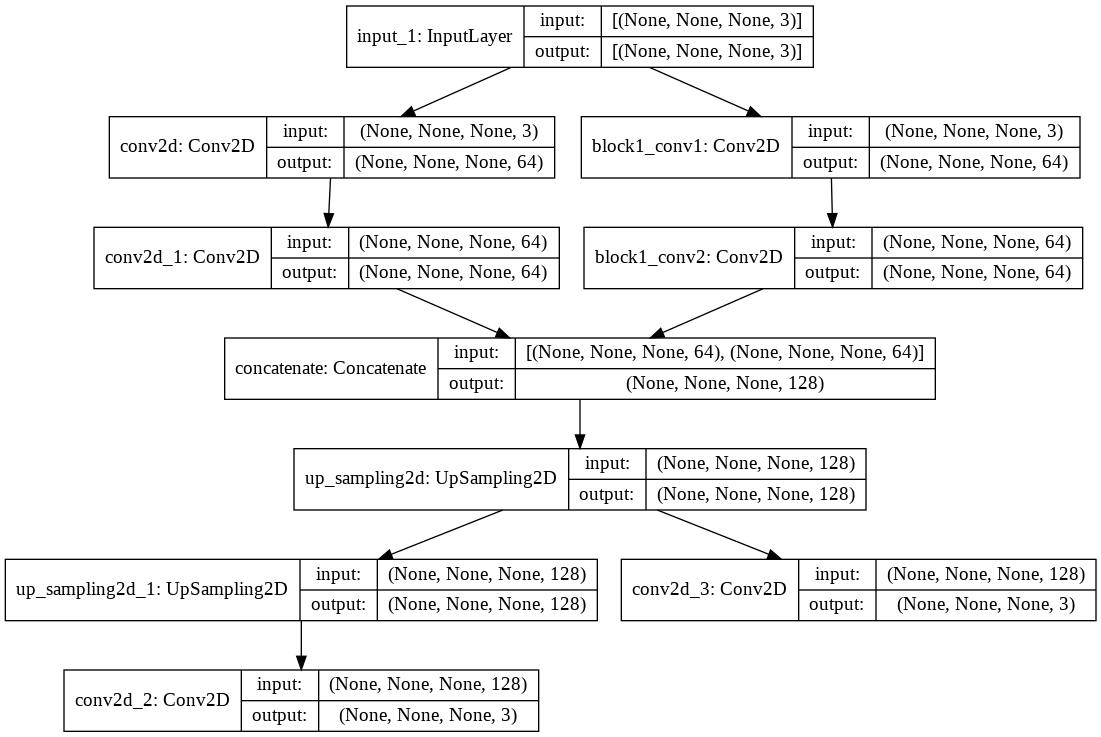

In [ ]:
model_vgg =vgg_model()
plot_model(model_vgg, "res_model.png",show_shapes=True)

In [ ]:
import tensorflow as tf
def psnr(y_true, y_pred):
  return tf.reduce_mean(tf.image.psnr(y_true, y_pred, max_val=1.0))

model_vgg.compile(optimizer='adam', loss='mse', metrics=[psnr])
train_gen,val_gen = get_generator(batch_size=16,two_outs=True,aug=True)
model_vgg.fit(train_gen,validation_data=val_gen,epochs=50,callbacks = get_callback(animation=True,name='vgg'))

Epoch 1/50
250/250 [==============================] - 2280s 9s/step - loss: 0.0551 - conv2d_3_loss: 0.0295 - conv2d_2_loss: 0.0256 - conv2d_3_psnr: 16.5538 - conv2d_2_psnr: 16.9342 - val_loss: 0.0172 - val_conv2d_3_loss: 0.0087 - val_conv2d_2_loss: 0.0085 - val_conv2d_3_psnr: 21.3813 - val_conv2d_2_psnr: 21.4558
Epoch 2/50
250/250 [==============================] - 165s 660ms/step - loss: 0.0169 - conv2d_3_loss: 0.0087 - conv2d_2_loss: 0.0083 - conv2d_3_psnr: 21.3695 - conv2d_2_psnr: 21.5299 - val_loss: 0.0150 - val_conv2d_3_loss: 0.0077 - val_conv2d_2_loss: 0.0073 - val_conv2d_3_psnr: 22.0311 - val_conv2d_2_psnr: 22.2294
Epoch 3/50
250/250 [==============================] - 165s 659ms/step - loss: 0.0158 - conv2d_3_loss: 0.0081 - conv2d_2_loss: 0.0077 - conv2d_3_psnr: 21.7010 - conv2d_2_psnr: 21.9348 - val_loss: 0.0142 - val_conv2d_3_loss: 0.0073 - val_conv2d_2_loss: 0.0069 - val_conv2d_3_psnr: 22.3658 - val_conv2d_2_psnr: 22.5845
Epoch 4/50
250/250 [==============================] - 

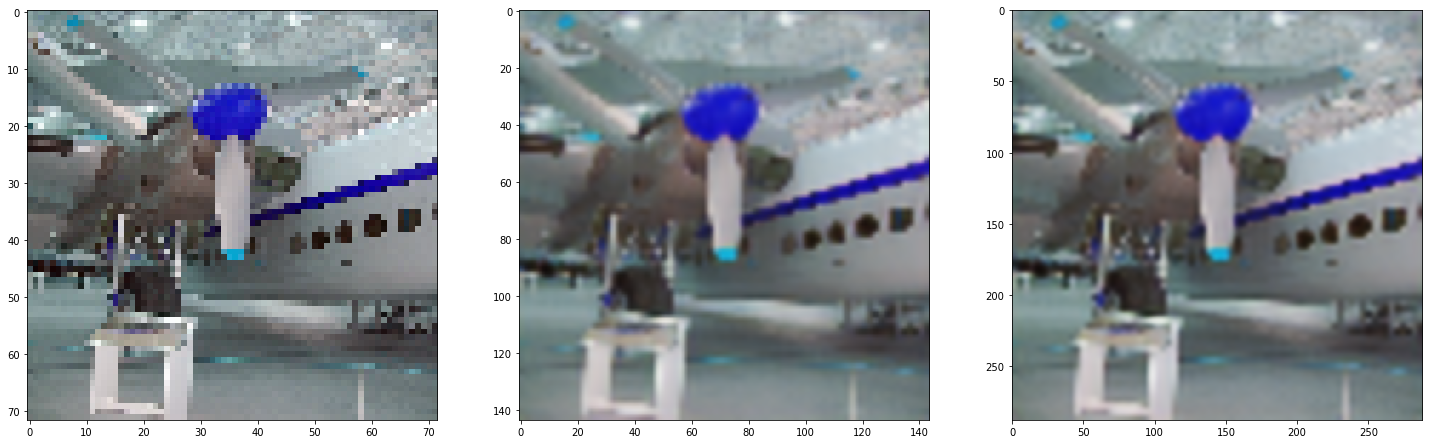

In [ ]:
preds = model_vgg.predict(test)
img_plot(0,test,preds[0],preds[1])

In [ ]:
psnr(preds[0],test_mid),psnr(preds[1],test_large)

(<tf.Tensor: shape=(), dtype=float32, numpy=23.89377>,
 <tf.Tensor: shape=(), dtype=float32, numpy=24.204145>)

# depth to space vgg model

In [ ]:
from tensorflow.nn import  depth_to_space

def depthvvg_model():
  input = Input(shape=(None, None, 3))
  x = Conv2D(64, kernel_size=3, activation='relu', padding='same')(input)
  x = Conv2D(64, kernel_size=3, activation='relu', padding='same')(x)
  vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=input)
  vgg16 = Model(input, vgg16.get_layer('block1_conv2').output)
  for l in vgg16.layers:
    l.trainable=False
  x =  Concatenate()([x, vgg16.outputs[0]])
  x = depth_to_space(x, block_size=2)
  x = Conv2D(64,3, activation='sigmoid', padding='same')(x)


  bigger = depth_to_space(x, block_size=2)
  bigger_out = Conv2D(3, (1,1), activation='sigmoid', padding='same')(bigger)
  x = Conv2D(3, (1,1), activation='sigmoid', padding='same')(x)

  model = Model(inputs=input, outputs=[x,bigger_out])
  return model

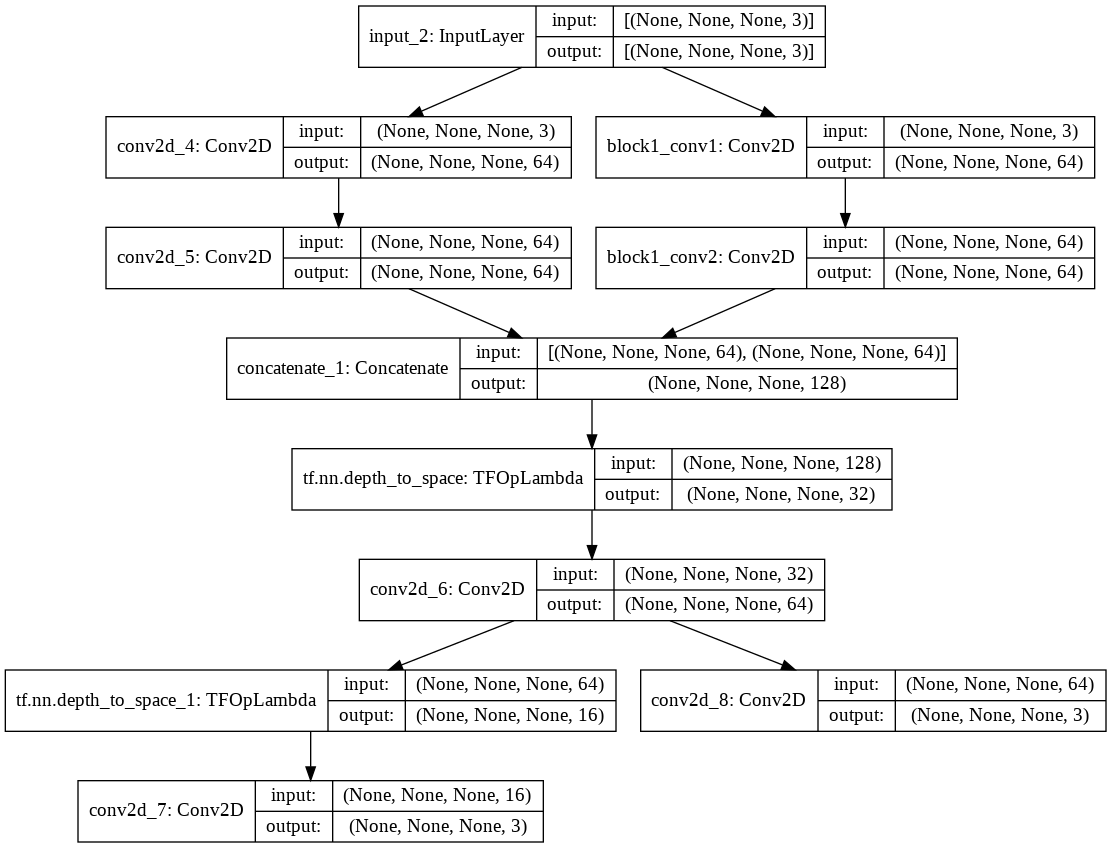

In [ ]:
depth_model =depthvvg_model()
plot_model(depth_model, "res_model.png",show_shapes=True)

In [ ]:

depth_model.compile(optimizer='adam', loss='mse', metrics=[psnr])
train_gen,val_gen = get_generator(batch_size=16,two_outs=True,aug=True)
depth_model.fit(train_gen,validation_data=val_gen,epochs=50,callbacks = get_callback(name='depth'))



Epoch 1/50
250/250 [==============================] - 137s 540ms/step - loss: 0.0947 - conv2d_8_loss: 0.0432 - conv2d_7_loss: 0.0515 - conv2d_8_psnr: 15.3892 - conv2d_7_psnr: 13.9758 - val_loss: 0.0206 - val_conv2d_8_loss: 0.0088 - val_conv2d_7_loss: 0.0118 - val_conv2d_8_psnr: 21.3191 - val_conv2d_7_psnr: 19.8897
Epoch 2/50
250/250 [==============================] - 132s 528ms/step - loss: 0.0204 - conv2d_8_loss: 0.0090 - conv2d_7_loss: 0.0114 - conv2d_8_psnr: 21.1308 - conv2d_7_psnr: 20.0236 - val_loss: 0.0161 - val_conv2d_8_loss: 0.0076 - val_conv2d_7_loss: 0.0085 - val_conv2d_8_psnr: 22.0925 - val_conv2d_7_psnr: 21.4505
Epoch 3/50
250/250 [==============================] - 134s 535ms/step - loss: 0.0166 - conv2d_8_loss: 0.0079 - conv2d_7_loss: 0.0087 - conv2d_8_psnr: 21.8040 - conv2d_7_psnr: 21.3101 - val_loss: 0.0149 - val_conv2d_8_loss: 0.0073 - val_conv2d_7_loss: 0.0076 - val_conv2d_8_psnr: 22.3008 - val_conv2d_7_psnr: 21.9796
Epoch 4/50
250/250 [==============================] 

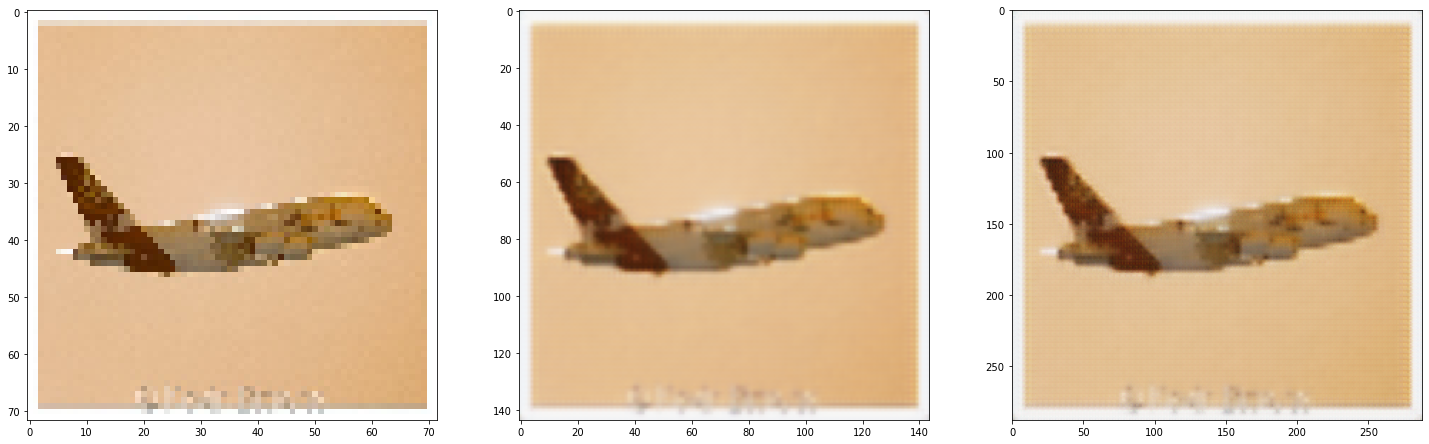

In [ ]:
preds = depth_model.predict(test)
img_plot(5,test,preds[0],preds[1])

In [ ]:
psnr(preds[0],test_mid),psnr(preds[1],test_large)

(<tf.Tensor: shape=(), dtype=float32, numpy=23.984652>,
 <tf.Tensor: shape=(), dtype=float32, numpy=24.145782>)

# VGG model training animation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
from IPython.display import HTML

fig = plt.figure()



ims = []
for i in range(len(gif_preds)):
    im = plt.imshow(gif_preds[i], animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

rc('animation', html='jshtml')
ani

Output hidden; open in https://colab.research.google.com to view.

# dcscn

when i've start reserching about super resulotion i came across this article: https://arxiv.org/abs/1707.05425

I'll try to implement this model which supposed to have more then 30 psnr.

the model in the article is for scaling by x2 so at first i'll try to use two ReconstructionNetwork for the x4 scale. I'll use the conv2d transpose.

In [12]:
def get_block(filters,shape,input):
  x = Conv2D(filters,shape, padding='same')(input)
  x=PReLU(shared_axes=[1,2])(x)
  return Dropout(0.2)(x)
def ReconstructionNetwork(input):
  A1=get_block(64,(1,1),input)
  B1 = get_block(32,(1,1),input)
  B2 = get_block(32,(3,3),B1)
  x=Concatenate()([A1,B2])
  return x

In [ ]:
import tensorflow as tf
features_filters = [96,76,65,55,47,39,32]
recon_filters = [64,32,32,4]
def dcscn():
  input = Input(shape=(None, None, 3))
  bi_cubic = tf.image.resize(input, [144,144],method='bicubic')
  bi_cubic2 = tf.image.resize(input, [288,288],method='bicubic')
  x = input
  feature_outputs=[]
  for i in range(7):
    x = get_block(features_filters[i],(3,3),x)
    feature_outputs.append(x)

  x=Concatenate()(feature_outputs)
  recon = ReconstructionNetwork(x)
  out1 = Conv2DTranspose(3, (1,1),strides=(2,2),input_shape=(None, None, 3),padding='same')(recon)
  out1 = Add()([bi_cubic,out1])
  recon2 =ReconstructionNetwork(out1)
  out2 = Conv2DTranspose(3, (1,1),strides=(2,2),input_shape=(None, None, 3),padding='same')(recon2)
  out1 = Conv2D(3, (1,1), activation='sigmoid', padding='same')(out1)
  out2 = Add()([bi_cubic2,out2])

  out2 = Conv2D(3, (1,1), activation='sigmoid', padding='same')(out2)
  model = Model(inputs=input, outputs=[out1,out2])
  return model

In [ ]:
dcscn_model = dcscn()

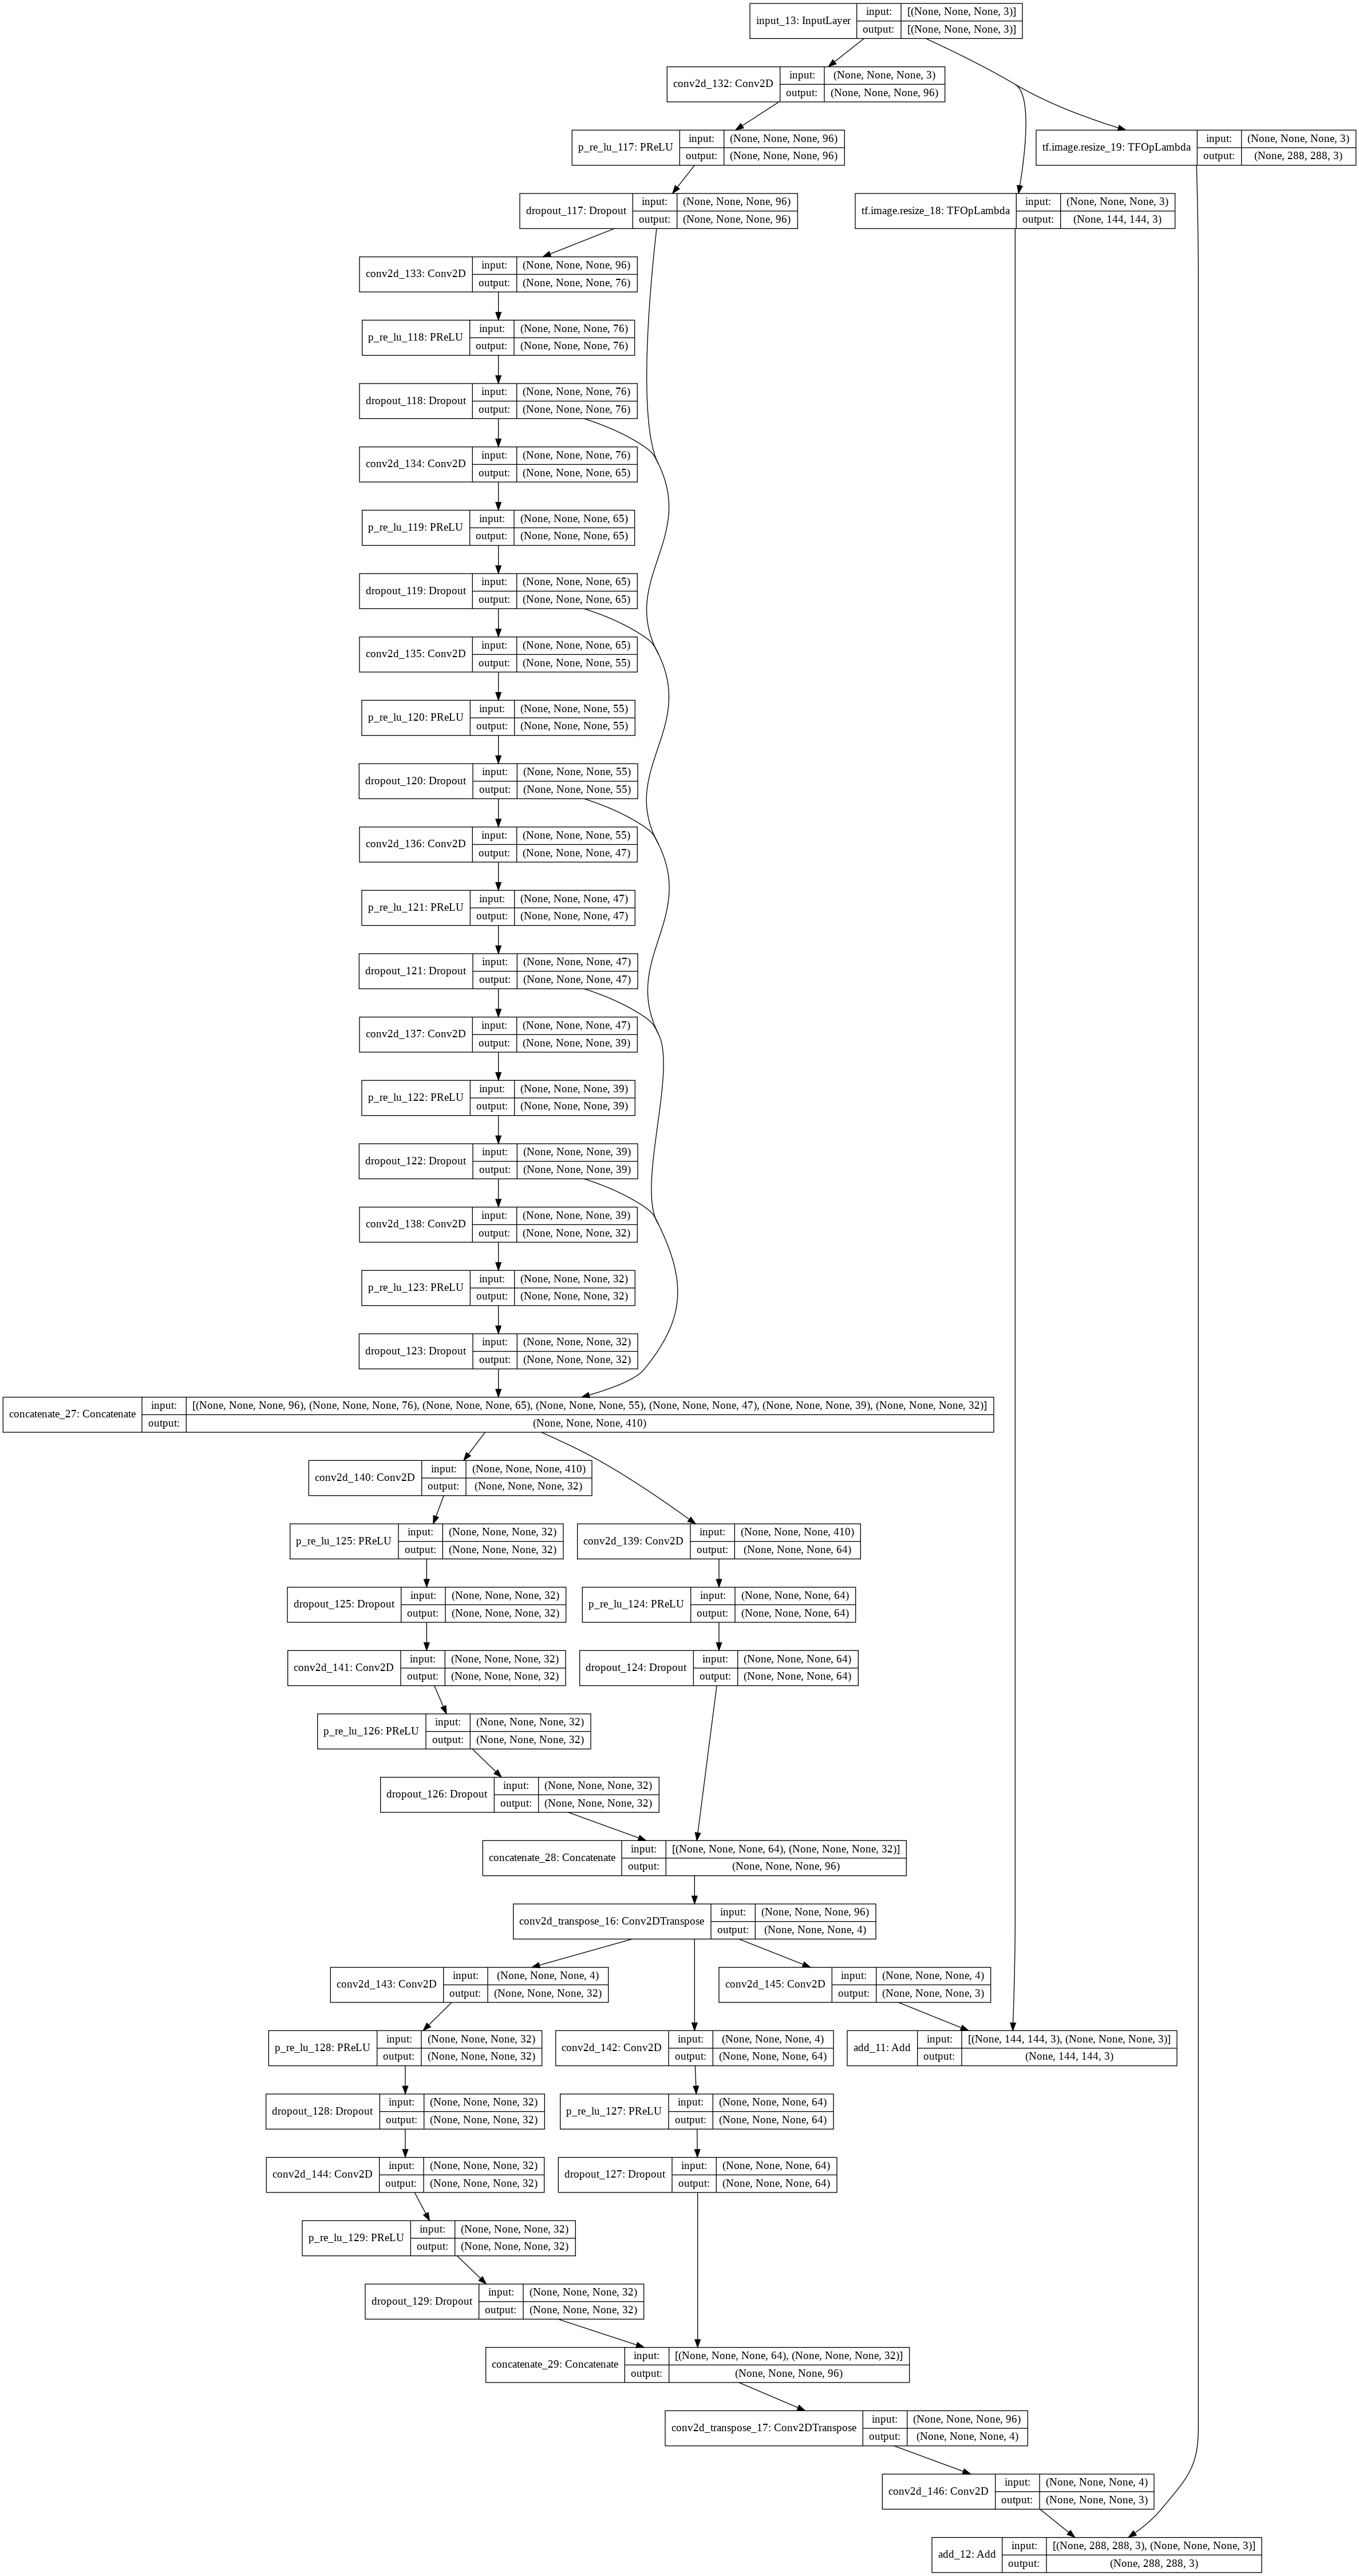

In [ ]:

dcscn_model = dcscn()
plot_model(dcscn_model, "res_model.png",show_shapes=True)

In [ ]:
dcscn_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_132 (Conv2D)             (None, None, None, 9 2688        input_13[0][0]                   
__________________________________________________________________________________________________
p_re_lu_117 (PReLU)             (None, None, None, 9 96          conv2d_132[0][0]                 
__________________________________________________________________________________________________
dropout_117 (Dropout)           (None, None, None, 9 0           p_re_lu_117[0][0]                
____________________________________________________________________________________________

In [ ]:

dcscn_model.compile(optimizer='adam', loss='mse', metrics=[psnr])
train_gen,val_gen = get_generator(batch_size=32,two_outs=True)
history = dcscn_model.fit(train_gen,validation_data=val_gen,epochs=50)



Epoch 1/50
125/125 [==============================] - 64s 475ms/step - loss: 0.3938 - add_11_loss: 0.1898 - add_12_loss: 0.2040 - add_11_psnr: 7.2546 - add_12_psnr: 6.9602 - val_loss: 0.2868 - val_add_11_loss: 0.1395 - val_add_12_loss: 0.1472 - val_add_11_psnr: 8.5563 - val_add_12_psnr: 8.3223
Epoch 2/50
125/125 [==============================] - 58s 466ms/step - loss: 0.2595 - add_11_loss: 0.1246 - add_12_loss: 0.1349 - add_11_psnr: 9.0766 - add_12_psnr: 8.7183 - val_loss: 0.1776 - val_add_11_loss: 0.0806 - val_add_12_loss: 0.0970 - val_add_11_psnr: 10.9445 - val_add_12_psnr: 10.1390
Epoch 3/50
125/125 [==============================] - 59s 467ms/step - loss: 0.1565 - add_11_loss: 0.0699 - add_12_loss: 0.0866 - add_11_psnr: 11.6056 - add_12_psnr: 10.6542 - val_loss: 0.1014 - val_add_11_loss: 0.0430 - val_add_12_loss: 0.0585 - val_add_11_psnr: 13.7001 - val_add_12_psnr: 12.3452
Epoch 4/50
125/125 [==============================] - 59s 468ms/step - loss: 0.0904 - add_11_loss: 0.0381 - a

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


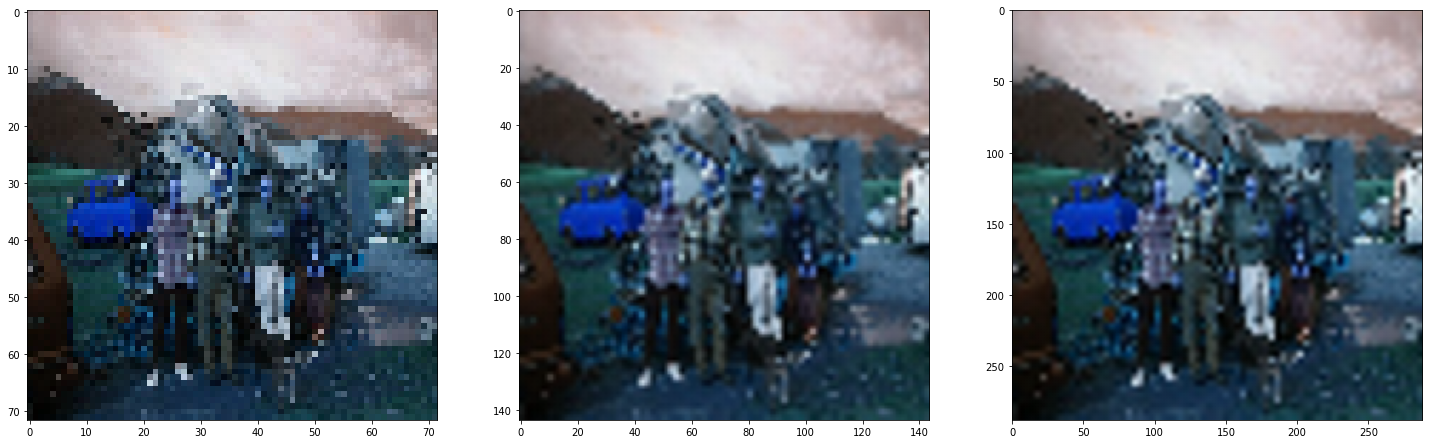

In [ ]:
preds = dcscn_model.predict(test)
img_plot(10,test,preds[0],preds[1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


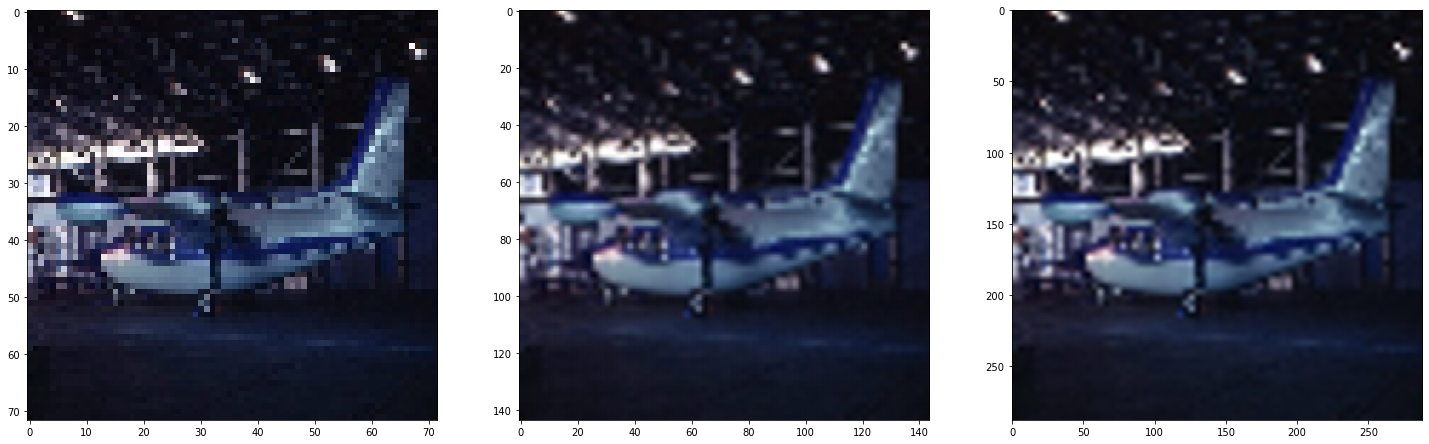

In [ ]:
img_plot(2,test,preds[0],preds[1])

the model didn't succeed to get to 30 psnr, and we can see the x4 prediction doesn't look better then our previous models.
I'll now try to use Upsampling instead of Conv2d transpose and use another Conv2d with 3 filter.

In [ ]:
from tensorflow.keras.layers import PReLU,Concatenate,Conv2DTranspose,UpSampling2D
import tensorflow as tf
features_filters = [96,76,65,55,47,39,32]
def dcscn_up():
  input = Input(shape=(None, None, 3))
  x = input
  feature_outputs=[]
  for i in range(7):
    x = get_block(features_filters[i],(3,3),x)
    feature_outputs.append(x)
  x=Concatenate()(feature_outputs)
  recon = ReconstructionNetwork(x)
  out1 = UpSampling2D(size=2,interpolation='bilinear')(recon)
  recon2 =ReconstructionNetwork(out1)
  out2 = UpSampling2D(size=2,interpolation='bilinear')(recon2)
  out1 = Conv2D(3, (1,1), activation='sigmoid', padding='same')(out1)
  out2 = Conv2D(3, (1,1), activation='sigmoid', padding='same')(out2)
  model = Model(inputs=input, outputs=[out1,out2])
  return model

In [ ]:
dcscnup_model = dcscn_up()

In [ ]:
dcscnup_model.summary()

Model: "model_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_60 (Conv2D)              (None, None, None, 9 2688        input_14[0][0]                   
__________________________________________________________________________________________________
p_re_lu_13 (PReLU)              (None, None, None, 9 96          conv2d_60[0][0]                  
__________________________________________________________________________________________________
dropout_13 (Dropout)            (None, None, None, 9 0           p_re_lu_13[0][0]                 
___________________________________________________________________________________________

In [ ]:
dcscnup_model.compile(optimizer='adam', loss='mse', metrics=[psnr])
train_gen,val_gen = get_generator(batch_size=10,two_outs=True,aug=True)
history = dcscnup_model.fit(train_gen,validation_data=val_gen,epochs=25,callbacks = get_callback(name='dsnv'))


Epoch 1/25
400/400 [==============================] - 365s 906ms/step - loss: 0.0250 - conv2d_73_loss: 0.0123 - conv2d_74_loss: 0.0127 - conv2d_73_psnr: 20.0606 - conv2d_74_psnr: 19.9218 - val_loss: 0.0136 - val_conv2d_73_loss: 0.0069 - val_conv2d_74_loss: 0.0066 - val_conv2d_73_psnr: 22.5784 - val_conv2d_74_psnr: 22.7230
Epoch 2/25
400/400 [==============================] - 357s 891ms/step - loss: 0.0148 - conv2d_73_loss: 0.0075 - conv2d_74_loss: 0.0073 - conv2d_73_psnr: 22.0896 - conv2d_74_psnr: 22.1469 - val_loss: 0.0129 - val_conv2d_73_loss: 0.0066 - val_conv2d_74_loss: 0.0063 - val_conv2d_73_psnr: 22.8940 - val_conv2d_74_psnr: 23.0239
Epoch 3/25
400/400 [==============================] - 357s 893ms/step - loss: 0.0143 - conv2d_73_loss: 0.0073 - conv2d_74_loss: 0.0070 - conv2d_73_psnr: 22.2413 - conv2d_74_psnr: 22.3437 - val_loss: 0.0119 - val_conv2d_73_loss: 0.0061 - val_conv2d_74_loss: 0.0058 - val_conv2d_73_psnr: 23.3820 - val_conv2d_74_psnr: 23.5886
Epoch 4/25
400/400 [========

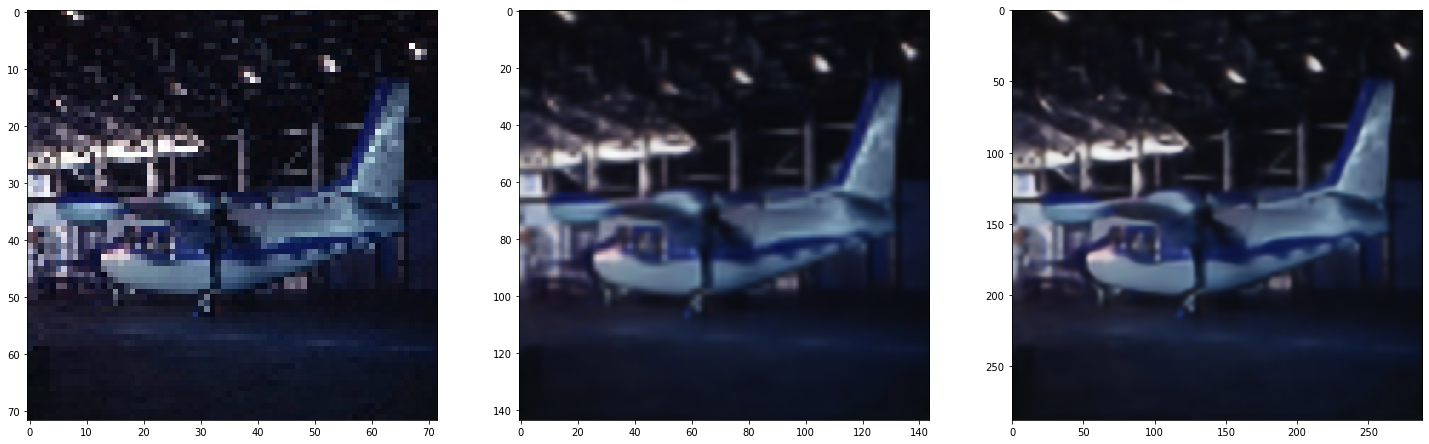

In [ ]:
preds = dcscnup_model.predict(test)
img_plot(2,test,preds[0],preds[1])

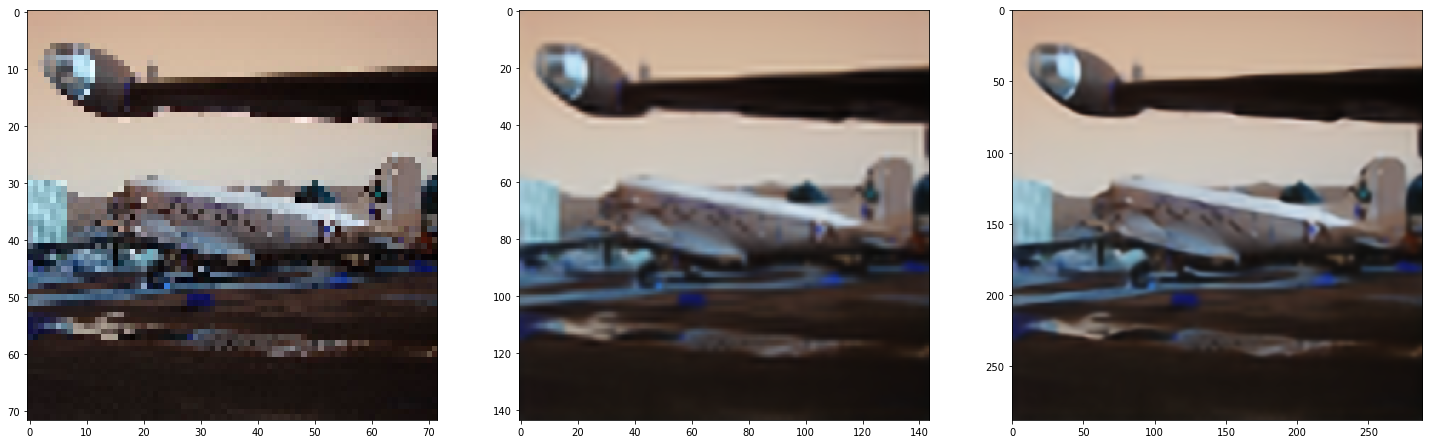

In [ ]:
img_plot(9,test,preds[0],preds[1])

we can see that the x4 prediction looks better. Now I'll try to use the x2 scaling as input and do the whole procces all over again for the x4 scale.

In [11]:
import tensorflow as tf
features_filters = [96,76,65,55,47,39,32]
recon_filters = [64,32,32,4]
def twice_dcscn_up():
  input = Input(shape=(None, None, 3))
  bi_cubic = tf.image.resize(input, [144,144],method='bicubic')
  x = input
  feature_outputs=[]
  for i in range(7):
    x = get_block(features_filters[i],(3,3),x)
    feature_outputs.append(x)

  x=Concatenate()(feature_outputs)
  recon = ReconstructionNetwork(x)
  out1 = UpSampling2D(size=2,interpolation='bilinear')(recon)
  out1 = Conv2D(3, (1,1), activation='sigmoid', padding='same')(out1)

  out1 = Add()([bi_cubic,out1])
  
  out1 = Conv2D(3, (1,1), activation='sigmoid', padding='same',name='mid')(out1)
  bi_cubic2 = tf.image.resize(input, [288,288],method='bicubic')
  x = out1
  feature_outputs=[]
  for i in range(7):
    x = get_block(features_filters[i],(3,3),x)
    feature_outputs.append(x)
  x=Concatenate()(feature_outputs)
  recon2 =ReconstructionNetwork(x)
  out2 = UpSampling2D(size=2,interpolation='bilinear')(recon2)
  out2 = Conv2D(3, (1,1), activation='sigmoid', padding='same')(out2)
  out2 = Add()([bi_cubic2,out2])

  out2 = Conv2D(3, (1,1), activation='sigmoid', padding='same',name='big')(out2)
  model = Model(inputs=input, outputs=[out1,out2])
  return model

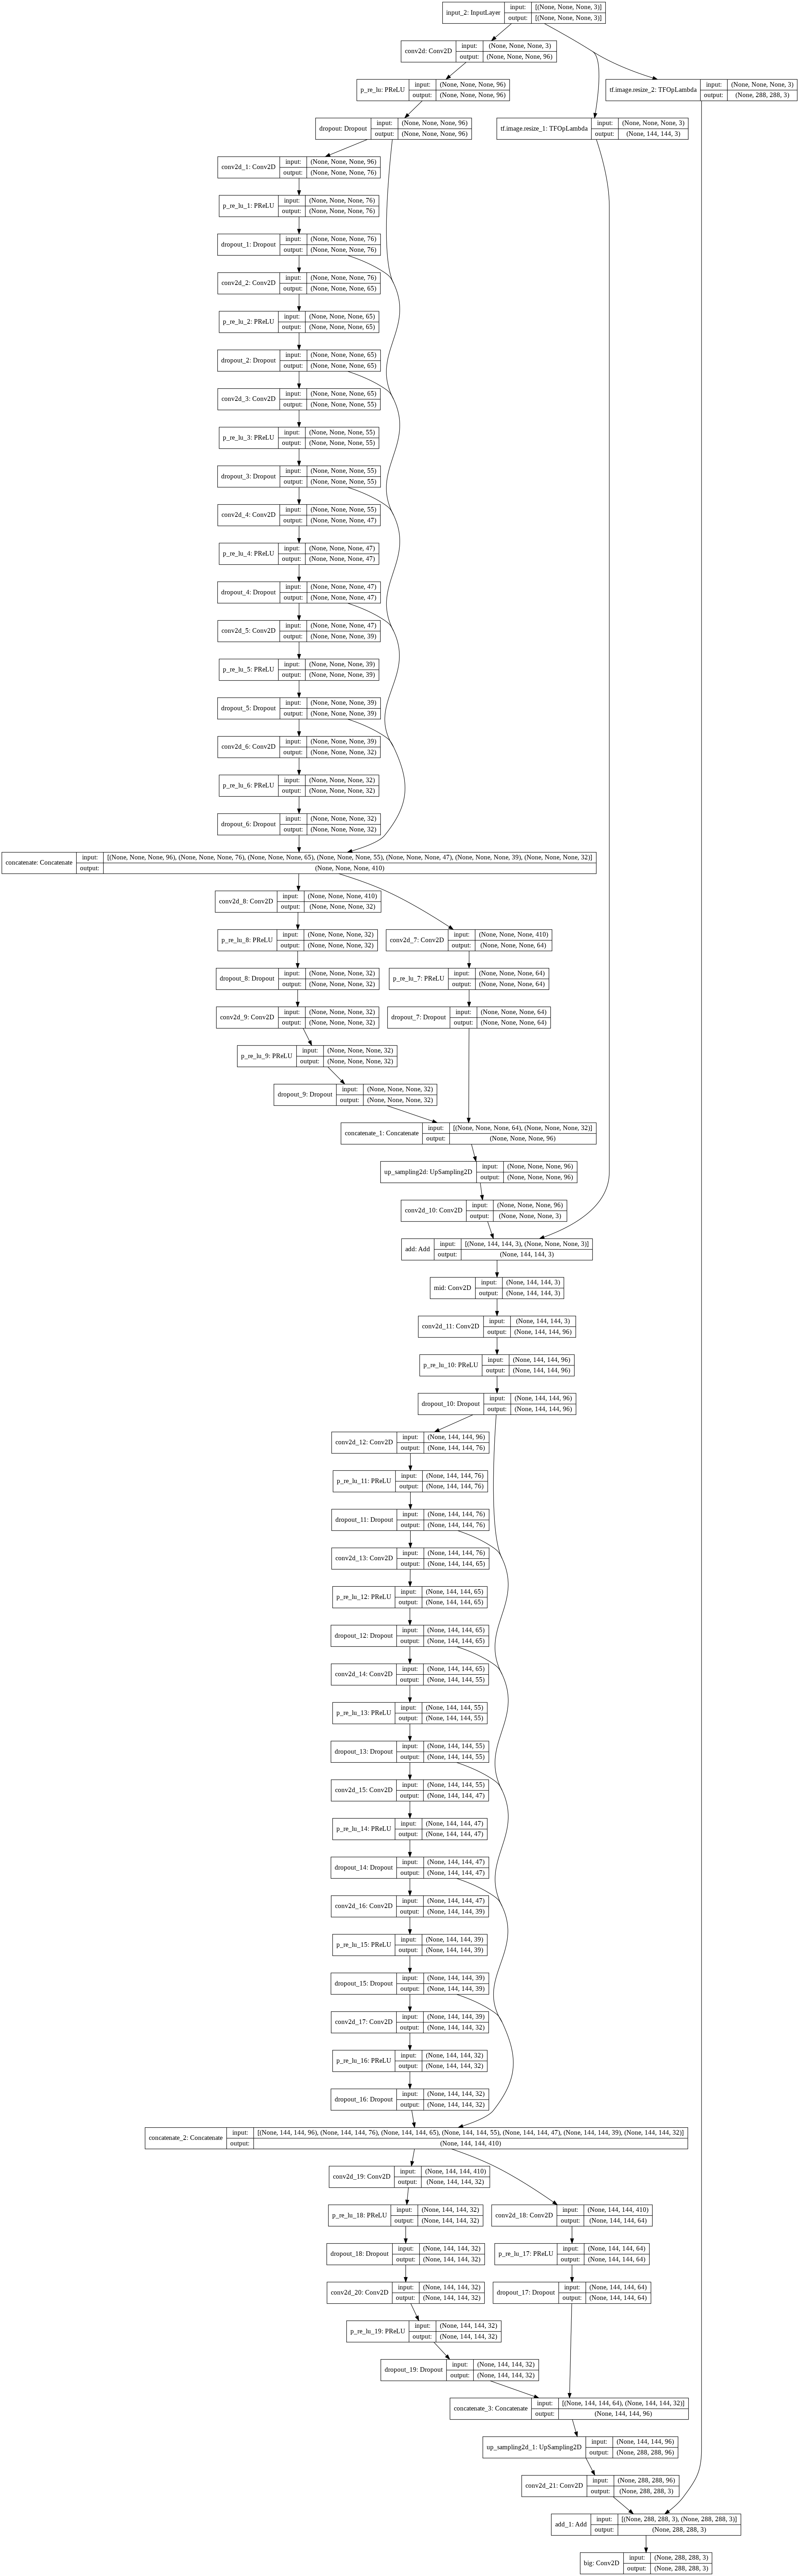

In [ ]:
twice = twice_dcscn_up()
plot_model(twice, "res_model.png",show_shapes=True)

In [ ]:
twice.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 9 2688        input_2[0][0]                    
__________________________________________________________________________________________________
p_re_lu (PReLU)                 (None, None, None, 9 96          conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, None, None, 9 0           p_re_lu[0][0]                    
______________________________________________________________________________________________

In [ ]:

twice.compile(optimizer='adam', loss='mse', metrics=[psnr])
train_gen,val_gen = get_generator(batch_size=10,two_outs=True,aug=True)
history = twice.fit(train_gen,validation_data=val_gen,epochs=25,callbacks = get_callback(name='twice'))



Epoch 1/25
400/400 [==============================] - 455s 1s/step - loss: 0.0230 - mid_loss: 0.0112 - big_loss: 0.0118 - mid_psnr: 20.1410 - big_psnr: 19.9440 - val_loss: 0.0197 - val_mid_loss: 0.0095 - val_big_loss: 0.0101 - val_mid_psnr: 21.0196 - val_big_psnr: 20.7333
Epoch 2/25
400/400 [==============================] - 452s 1s/step - loss: 0.0198 - mid_loss: 0.0098 - big_loss: 0.0100 - mid_psnr: 20.7501 - big_psnr: 20.6823 - val_loss: 0.0173 - val_mid_loss: 0.0087 - val_big_loss: 0.0086 - val_mid_psnr: 21.4562 - val_big_psnr: 21.4977
Epoch 3/25
400/400 [==============================] - 452s 1s/step - loss: 0.0182 - mid_loss: 0.0092 - big_loss: 0.0090 - mid_psnr: 21.0808 - big_psnr: 21.1135 - val_loss: 0.0159 - val_mid_loss: 0.0081 - val_big_loss: 0.0077 - val_mid_psnr: 21.8131 - val_big_psnr: 21.9536
Epoch 4/25
400/400 [==============================] - 452s 1s/step - loss: 0.0167 - mid_loss: 0.0085 - big_loss: 0.0082 - mid_psnr: 21.4260 - big_psnr: 21.5718 - val_loss: 0.0149 - 

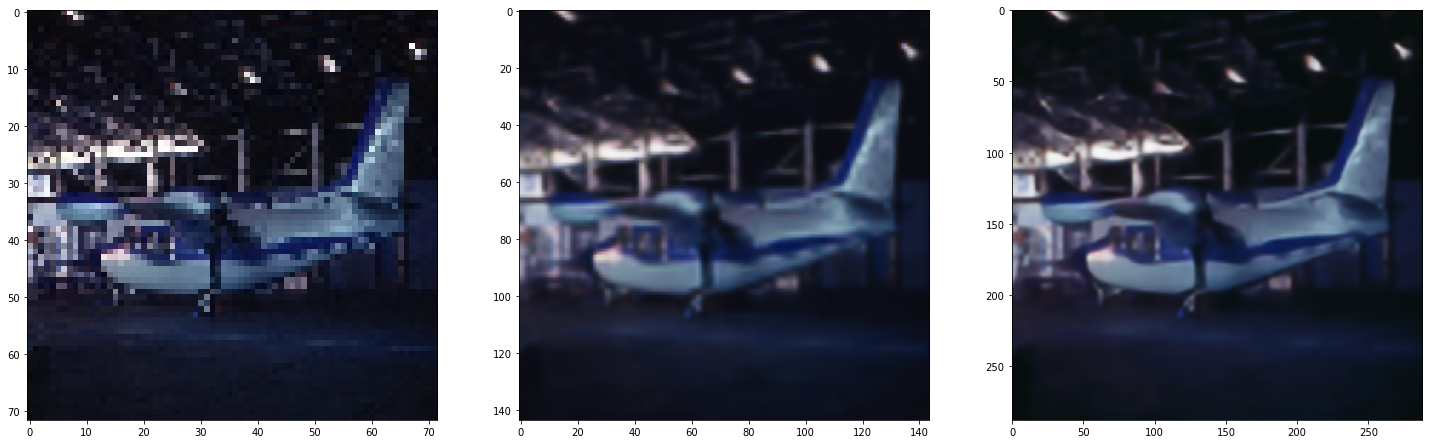

In [ ]:
preds = twice.predict(test)
img_plot(2,test,preds[0],preds[1])

In [ ]:
psnr(preds[0],test_mid),psnr(preds[1],test_large)

(<tf.Tensor: shape=(), dtype=float32, numpy=24.109606>,
 <tf.Tensor: shape=(), dtype=float32, numpy=24.568413>)

# summary

I've choose to compare between the vgg model, depth space vgg, up sampaling dcscn and the last dcscn.

In [ ]:
depth_model =depthvvg_model()
depth_model.load_weights('/content/drive/MyDrive/ass4/best_model_weights_depth.h5')


model_vgg =vgg_model()
model_vgg.load_weights('/content/drive/MyDrive/ass4/best_model_weights_vgg.h5')

dcscnup_model = dcscn_up()
dcscnup_model.load_weights('/content/drive/MyDrive/ass4/best_model_weights_dsnv.h5')

twice = twice_dcscn_up()
twice.load_weights('/content/drive/MyDrive/ass4/best_model_weights_twice.h5')

models = {'depth':depth_model,'vgg':model_vgg,'dcscnup_model':dcscnup_model, 'twice_dcscn':twice}
predictions = {}
for model in models.keys():
  predictions[model] = models[model].predict(test)

Text(0, 0.5, 'psnr')

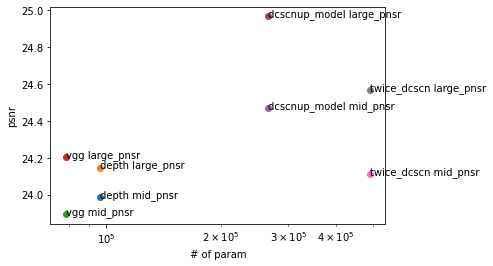

In [ ]:
fig,ax = plt.subplots()

for model in models.keys():
  ax.scatter(models[model].count_params(), [psnr(predictions[model][0],test_mid)],label=model +' mid_pnsr')
  ax.scatter(models[model].count_params(), [psnr(predictions[model][1],test_large)],label=model +' large_pnsr')
  ax.annotate(model +' mid_pnsr',[models[model].count_params(), psnr(predictions[model][0],test_mid)])
  ax.annotate(model +' large_pnsr',[models[model].count_params(), psnr(predictions[model][1],test_large)])


# ax.legend(bbox_to_anchor=(1.05, 1))
ax.set_xscale('log')
ax.set_xlabel('# of param')
ax.set_ylabel('psnr')

depth results:

In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual
@interact_manual
def x(i=(0,11,1)):
  img_plot(i,test,predictions['depth'][0],predictions['depth'][1])

interactive(children=(IntSlider(value=5, description='i', max=11), Button(description='Run Interact', style=Bu…

vgg results:

In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual
@interact_manual
def x(i=(0,11,1)):
  img_plot(i,test,predictions['vgg'][0],predictions['vgg'][1])

interactive(children=(IntSlider(value=5, description='i', max=11), Button(description='Run Interact', style=Bu…

dcscnup_model:

In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual
@interact_manual
def x(i=(0,11,1)):
  img_plot(i,test,predictions['dcscnup_model'][0],predictions['dcscnup_model'][1])

interactive(children=(IntSlider(value=5, description='i', max=11), Button(description='Run Interact', style=Bu…

twice_dcscn

In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual
@interact_manual
def x(i=(0,11,1)):
  img_plot(i,test,predictions['twice_dcscn'][0],predictions['twice_dcscn'][1])

interactive(children=(IntSlider(value=5, description='i', max=11), Button(description='Run Interact', style=Bu…

In [13]:
twice = twice_dcscn_up()
twice.load_weights('/content/drive/MyDrive/ass4/best_model_weights_twice.h5')

In [14]:
img = cv2.imread('/content/IMG_8518.JPG')/255

In [20]:
d = []
d.append(img)
p = twice.predict(np.array(d))

ValueError: ignored

In [19]:
np.array(d).shape

(1, 480, 640, 3)